# Reconstruct Precipitation in Kelvin Waves Band

## Import package

In [41]:
import h5py as h5
import dask.dataframe as dd
import numpy as np
import joblib as jl
from matplotlib import pyplot as plt

## Functions

### Load data

In [42]:
def load_data(fname, var):
    with h5.File(fname, 'r') as f:
        data = f[var][:]

    return data

## Load data

In [43]:
# case name
case = 'PR50'

# file names
## source directory
src_dic = '/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/'

## varaibles list
var_list = ['prec']

data = jl.Parallel(n_jobs=12)(
    jl.delayed(load_data)(f'{src_dic}{case}/{var}/{case}_500_20000day_6hourly_{var}.dat', var)
    for var in var_list
)


data = {
    var: data[i]
    for i, var in enumerate(var_list)
}

data = {
    var: data[var] - data[var].mean(axis=0)
    for var in data.keys()
}

data['prec'] = data['prec'] * 86400


print(data.keys())

dict_keys(['prec'])


## Apply FFT on data

In [44]:
def FFT(data):
    data_fft = np.fft.fftshift(np.fft.fft2(data))[:, ::-1]
    
    return data_fft

data_fft = {
    var: np.stack([
        FFT(data[var][:, i, :])
        for i in range(data[var].shape[1])
    ], axis=1)
    for var in data.keys()
}

### Apply Bandpass filter on the dataset


#### Setup condition of the bandpass filter


In [45]:
wn = np.linspace(-63, 64, 128)
fr = np.linspace(-2, 2, 78000)

wnm, frm = np.meshgrid(wn, fr)

# Kelvin wave dispersion relation
kel_curves = lambda ed, k: (86400/(2*np.pi*6.371e6))*np.sqrt(9.81*ed)*k

cond = (
    (wnm >= 1) & (wnm < 6) &
    (frm >= 1/20) & (frm <= 0.3) &
    (frm <= kel_curves(25, wnm)) & (frm >= kel_curves(8, wnm))
)

data_filted = {
    var: np.stack([
        np.where(
            cond, data[var][:, i, :]*2, 0)
        for i in range(data_fft['prec'].shape[1])
    ], axis=1)
    for var in data_fft.keys()
}

print(data_filted['prec'].shape)

(78000, 64, 128)


## Inverse FFT


In [46]:
data_ifft = {
    var: np.stack([
        np.fft.ifft2(np.fft.ifftshift(data_filted[var][:, i, :][:, ::-1])).real
        for i in range(data_filted[var].shape[1])
    ], axis=1
    )
    for var in data_filted.keys()
}

## Plot out the Kelvin wave precipitation

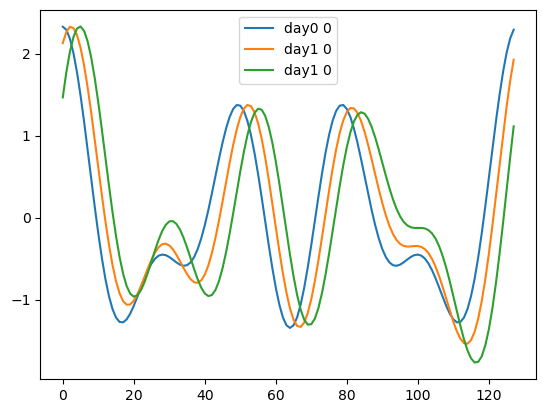

In [47]:
def normalize(data):
    return (data - data.mean(axis=0))/data.std(axis=0)


plt.plot(normalize(data_ifft['prec'][0, 32, :]), label='day0 0')
plt.plot(normalize(data_ifft['prec'][4, 32, :]), label='day1 0')
plt.plot(normalize(data_ifft['prec'][8, 32, :]), label='day1 0')
plt.legend()

## Save File 

In [48]:
output_dict = {
    var: data_ifft[var]
    for var in data_ifft.keys()
}

output_dict['description'] = 'Time-mean removed precipitation field (unit: mm/day) \
    in Kelvin wave Band (wn: 1~6, fr: 1/20~1/3, ed: 8~25)'
    
jl.dump(output_dict, f'/work/b11209013/2024_Research/Dycore/Kel_data/{case}_kelvin_wave_prec.joblib')

['/work/b11209013/2024_Research/Dycore/Kel_data/PR50_kelvin_wave_prec.joblib']